In [ ]:
# Cell 1: Setup & Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetB0, ResNet50V2, MobileNetV3Large
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Set GPU memory growth
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(f"🚀 GPU available: {physical_devices[0]}")
else:
    print("🖥️ Using CPU")

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

# Configuration
DATA_DIR = r"D:\Downloads\archive (1)\Dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
ARCHITECTURE = "resnet"  # or "efficientnet", "mobilenet"

print(f"\n⚙️ Configuration:")
print(f"    Dataset: {DATA_DIR}")
print(f"    Image size: {IMG_SIZE}")
print(f"    Batch size: {BATCH_SIZE}")
print(f"    Architecture: {ARCHITECTURE}")


🖥️ Using CPU
✅ All libraries imported successfully!
📦 TensorFlow version: 2.20.0

⚙️ Configuration:
   📁 Dataset: D:\Downloads\archive (1)\Dataset
   🎯 Image size: (224, 224)
   📦 Batch size: 32
   🧠 Architecture: resnet


In [ ]:
# Cell 2: Dataset Analysis
def analyze_dataset(data_dir):
    """Analyze the folder-based dataset"""
    data_path = Path(data_dir)
    
    print("Analyzing folder-based 3-class dataset...")
    
    if not data_path.exists():
        print(f"Dataset directory not found: {data_path}")
        return None
    
    # Find all subdirectories
    subdirs = [d for d in data_path.iterdir() if d.is_dir()]
    
    print(f"Found {len(subdirs)} subdirectories:")
    
    total_images = 0
    class_info = {}
    
    for subdir in subdirs:
        # Count images in this directory
        image_files = []
        for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']:
            image_files.extend(list(subdir.glob(ext)))
            image_files.extend(list(subdir.glob(ext.upper())))
        
        count = len(image_files)
        total_images += count
        class_info[subdir.name] = count
        
        print(f"   📂 {subdir.name}: {count} images")
    
    print(f"\nTotal images: {total_images}")
    
    if total_images == 0:
        print("No images found in dataset!")
        return None
    
    # Check class balance
    if class_info:
        min_count = min(class_info.values())
        max_count = max(class_info.values())
        balance_score = min_count / max_count if max_count > 0 else 0
        
        print(f"Class balance score: {balance_score:.2f}")
        if balance_score < 0.5:
            print("Dataset is very imbalanced - will use class weights")
        elif balance_score < 0.7:
            print("Dataset is somewhat imbalanced - will use class weights")
        else:
            print("Dataset is reasonably balanced")
    
    return class_info

# Run dataset analysis
dataset_info = analyze_dataset(DATA_DIR)


🔍 Analyzing folder-based 3-class dataset...
📁 Found 3 subdirectories:
   📂 mask_weared_incorrect: 5988 images
   📂 without_mask: 5988 images
   📂 with_mask: 5988 images

📊 Total images: 17964
⚖️ Class balance score: 1.00
✅ Dataset is reasonably balanced


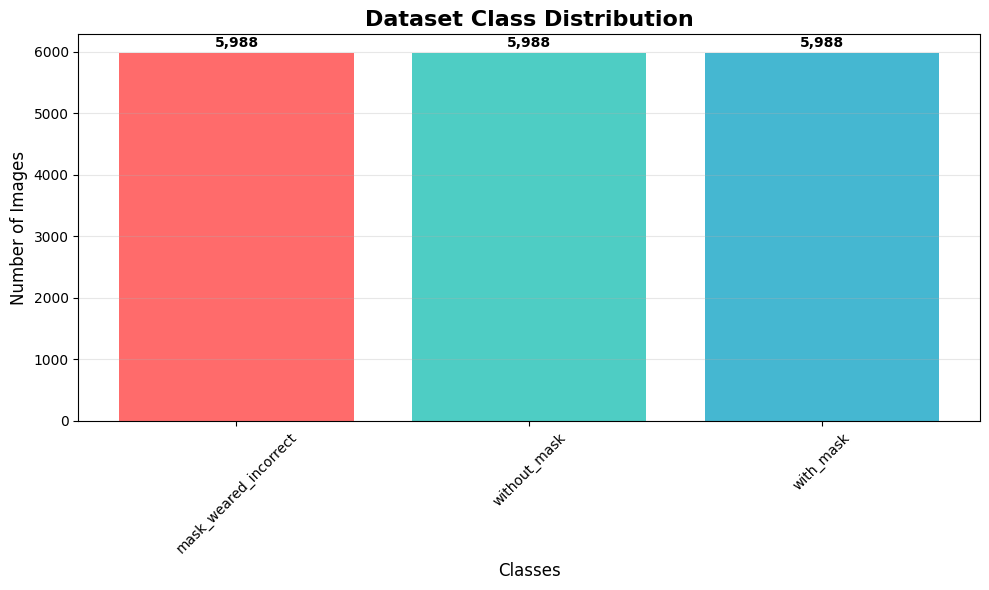


📈 Dataset Summary:
   Total images: 17,964
   Average per class: 5,988
   Most images: 5,988 (mask_weared_incorrect)
   Least images: 5,988 (mask_weared_incorrect)


In [ ]:
# Cell 3: Data Visualization
if dataset_info:
    # Create a bar chart of class distribution
    plt.figure(figsize=(10, 6))
    
    classes = list(dataset_info.keys())
    counts = list(dataset_info.values())
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    bars = plt.bar(classes, counts, color=colors)
    plt.title('Dataset Class Distribution', fontsize=16, fontweight='bold')
    plt.xlabel('Classes', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.xticks(rotation=45)
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 50,
                f'{count:,}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
    # Print summary statistics
    total = sum(counts)
    print(f"\n Dataset Summary:")
    print(f"   Total images: {total:,}")
    print(f"   Average per class: {total/len(classes):,.0f}")
    print(f"   Most images: {max(counts):,} ({classes[counts.index(max(counts))]})")
    print(f"   Least images: {min(counts):,} ({classes[counts.index(min(counts))]})")
else:
    print("No dataset information available")


In [ ]:
# Cell 4: Create Data Generators
def create_data_generators(data_dir, img_size=(224, 224), batch_size=32, validation_split=0.2):
    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=25,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        zoom_range=0.15,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest',
        validation_split=validation_split
    )
    
    # No augmentation for validation
    val_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        validation_split=validation_split
    )
    
    # Create generators
    try:
        train_generator = train_datagen.flow_from_directory(
            data_dir,
            target_size=img_size,
            batch_size=batch_size,
            class_mode='categorical',
            subset='training',
            shuffle=True
        )
        
        validation_generator = val_datagen.flow_from_directory(
            data_dir,
            target_size=img_size,
            batch_size=batch_size,
            class_mode='categorical',
            subset='validation',
            shuffle=False
        )
        
        print(f"Training samples: {train_generator.samples}")
        print(f"Validation samples: {validation_generator.samples}")
        print(f"Classes found: {list(train_generator.class_indices.keys())}")
        print(f"Class indices: {train_generator.class_indices}")
        
        return train_generator, validation_generator
        
    except Exception as e:
        print(f"Error creating data generators: {e}")
        return None, None

# Create data generators
train_gen, val_gen = create_data_generators(DATA_DIR, IMG_SIZE, BATCH_SIZE)


🔄 Creating data generators...
Found 7188 images belonging to 3 classes.
Found 1794 images belonging to 3 classes.
✅ Training samples: 7188
✅ Validation samples: 1794
✅ Classes found: ['mask_weared_incorrect', 'with_mask', 'without_mask']
✅ Class indices: {'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}


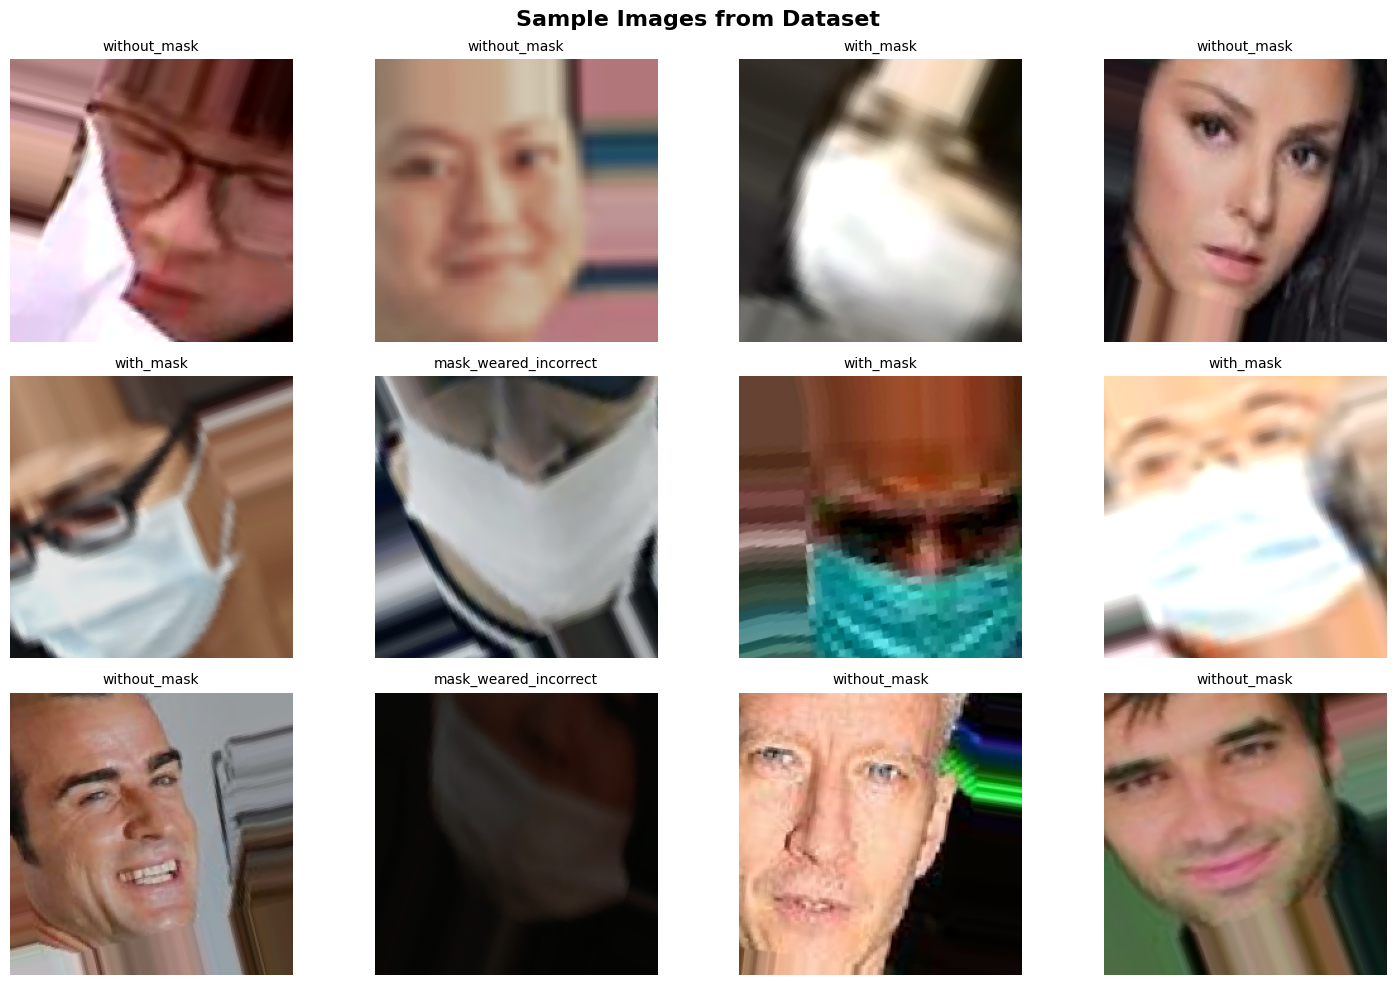

👁️ Displaying sample images from each class
🎯 Image shape: (224, 224, 3)
📊 Label shape: (3,)


In [ ]:
# Cell 5: Preview Some Images
if train_gen is not None:
    # Get a batch of images and labels
    images, labels = next(train_gen)
    
    # Class names
    class_names = list(train_gen.class_indices.keys())
    
    # Plot some sample images
    plt.figure(figsize=(15, 10))
    for i in range(min(12, len(images))):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i])
        
        # Get the class name
        class_idx = np.argmax(labels[i])
        class_name = class_names[class_idx]
        
        plt.title(f'{class_name}', fontsize=10)
        plt.axis('off')
    
    plt.suptitle('Sample Images from Dataset', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"Displaying sample images from each class")
    print(f"Image shape: {images[0].shape}")
    print(f"Label shape: {labels[0].shape}")
else:
    print("No data generators available for preview")


In [ ]:
# Cell 6: Build Model
def build_model(img_size=(224, 224), num_classes=3, architecture='resnet'):
    """Build the 3-class face mask detection model"""
    print(f"Building {architecture} model...")
    
    # Input layer
    inputs = layers.Input(shape=(*img_size, 3))
    
    # Base model selection with error handling
    try:
        if architecture == 'efficientnet':
            base_model = EfficientNetB0(
                weights='imagenet',
                include_top=False,
                input_tensor=inputs
            )
        elif architecture == 'resnet':
            base_model = ResNet50V2(
                weights='imagenet',
                include_top=False,
                input_tensor=inputs
            )
        elif architecture == 'mobilenet':
            base_model = MobileNetV3Large(
                weights='imagenet',
                include_top=False,
                input_tensor=inputs
            )
    except Exception as e:
        print(f"Error loading {architecture}: {e}")
        print("Falling back to simple custom CNN...")
        
        # Simple custom CNN as fallback
        x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Conv2D(64, (3, 3), activation='relu')(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Conv2D(128, (3, 3), activation='relu')(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Conv2D(256, (3, 3), activation='relu')(x)
        x = layers.GlobalAveragePooling2D()(x)
        
        # Create a simple model
        base_model = models.Model(inputs, x)
        base_model.trainable = True  # Custom model, so keep trainable
    
    # Freeze base model initially (except for custom CNN)
    if hasattr(base_model, 'layers') and len(base_model.layers) > 10:  # Pre-trained model
        base_model.trainable = False
    # Custom CNN stays trainable
    
    # Custom classification head
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    # Create model
    model = models.Model(inputs, outputs)
    
    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print("Model built successfully!")
    print(f"Total parameters: {model.count_params():,}")
    
    return model

# Build the model
model = build_model(IMG_SIZE, num_classes=3, architecture=ARCHITECTURE)


🏗️ Building resnet model...
✅ Model built successfully!
📊 Total parameters: 24,756,227


In [ ]:
# Cell 7: Model Summary & Architecture
if model:
    # Display model summary
    print("Model Architecture Summary:")
    model.summary()
    
    # Visualize model architecture (optional)
    try:
        tf.keras.utils.plot_model(
            model, 
            to_file='model_architecture.png', 
            show_shapes=True, 
            show_layer_names=True,
            dpi=150
        )
        print("Model architecture saved as 'model_architecture.png'")
    except:
        print("Could not create model visualization (requires graphviz)")
    
    # Show layer details
    print(f"\n Model Details:")
    print(f"   Input shape: {model.input_shape}")
    print(f"   Output shape: {model.output_shape}")
    print(f"   Total layers: {len(model.layers)}")
    print(f"   Trainable parameters: {model.count_params():,}")
else:
    print("No model available")


🔍 Model Architecture Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 24,756,227 (94.44 MB)

 Trainable params: 1,186,307 (4.53 MB)

 Non-trainable params: 23,569,920 (89.91 MB)

You must install pydot (`pip install pydot`) for `plot_model` to work.
📊 Model architecture saved as 'model_architecture.png'

🏗️ Model Details:
   Input shape: (None, 224, 224, 3)
   Output shape: (None, 3)
   Total layers: 199
   Trainable parameters: 24,756,227


In [ ]:
# Cell 8: Training Configuration
# Training parameters
EPOCHS = 5            # Change this to experiment with different training lengths
FINE_TUNE_EPOCHS = 3    # Fine-tuning epochs
PATIENCE = 10            # Early stopping patience

# Calculate training steps
if train_gen and val_gen:
    steps_per_epoch = max(1, train_gen.samples // train_gen.batch_size)
    validation_steps = max(1, val_gen.samples // val_gen.batch_size)
    
    print(f"Training Configuration:")
    print(f"Training epochs: {EPOCHS}")
    print(f"Fine-tuning epochs: {FINE_TUNE_EPOCHS}")
    print(f"Steps per epoch: {steps_per_epoch}")
    print(f"Validation steps: {validation_steps}")
    print(f"Estimated training time: {EPOCHS * steps_per_epoch * 0.5 / 60:.1f} minutes")

# Calculate class weights for balanced training
class_weights = None
if train_gen and hasattr(train_gen, 'classes'):
    unique_classes = np.unique(train_gen.classes)
    if len(unique_classes) > 1:
        class_weights_vals = compute_class_weight(
            'balanced',
            classes=unique_classes,
            y=train_gen.classes
        )
        class_weights = dict(zip(unique_classes, class_weights_vals))
        print(f"Class weights: {class_weights}")

# Setup callbacks
callbacks_list = [
    callbacks.ModelCheckpoint(
        'best_notebook_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print(f"Training setup complete!")
print(f"Model will be saved as: best_notebook_model.h5")


🎓 Training Configuration:
   📚 Training epochs: 5
   🔧 Fine-tuning epochs: 3
   📏 Steps per epoch: 224
   ✅ Validation steps: 56
   ⏱️ Estimated training time: 9.3 minutes
⚖️ Class weights: {np.int32(0): np.float64(1.0), np.int32(1): np.float64(1.0), np.int32(2): np.float64(1.0)}
✅ Training setup complete!
💾 Model will be saved as: best_notebook_model.h5


🔥 Phase 1: Training classification head...
⏱️ Starting training for 5 epochs...
Epoch 1/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.8441 - loss: 0.4639
Epoch 1: val_accuracy improved from None to 0.96987, saving model to best_notebook_model.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 190s 821ms/step - accuracy: 0.9002 - loss: 0.3140 - val_accuracy: 0.9699 - val_loss: 0.0915 - learning_rate: 0.0010
Epoch 2/5
  1/224 ━━━━━━━━━━━━━━━━━━━━ 1:50 497ms/step - accuracy: 0.9062 - loss: 0.3441
Epoch 2: val_accuracy improved from 0.96987 to 0.97042, saving model to best_notebook_model.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 32s 141ms/step - accuracy: 0.9062 - loss: 0.3441 - val_accuracy: 0.9704 - val_loss: 0.0912 - learning_rate: 0.0010
Epoch 3/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.9347 - loss: 0.1992
Epoch 3: val_accuracy improved from 0.97042 to 0.97489, saving model to best_notebook_model.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 183s 815ms/step - accuracy: 0.9419 - loss: 0.1746 - val_accuracy: 0.9749 - val_loss: 0.0849 - learning_rate: 0.0010
Epoch 4/5
  1/224 ━━━━━━━━━━━━━━━━━━━━ 1:49 489ms/step - accuracy: 0.9375 - loss: 0.1808
Epoch 4: val_accuracy improved from 0.97489 to 0.97600, saving model to best_notebook_model.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 28s 122ms/step - accuracy: 0.9375 - loss: 0.1808 - val_accuracy: 0.9760 - val_loss: 0.0839 - learning_rate: 0.0010
Epoch 5/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.9464 - loss: 0.1538
Epoch 5: val_accuracy improved from 0.97600 to 0.98661, saving model to best_notebook_model.h5


224/224 ━━━━━━━━━━━━━━━━━━━━ 163s 727ms/step - accuracy: 0.9487 - loss: 0.1448 - val_accuracy: 0.9866 - val_loss: 0.0513 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.
✅ Phase 1 training completed!


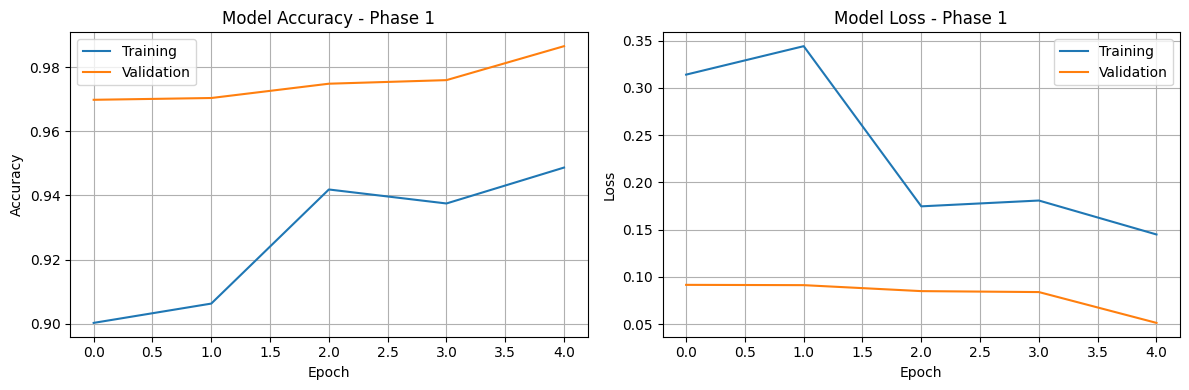

📊 Phase 1 Results:
   Final validation accuracy: 0.9866
   Final validation loss: 0.0513


In [ ]:
# Cell 9: Phase 1 Training (Head Only)
if model and train_gen and val_gen:
    print("Phase 1: Training classification head...")
    print(f"Starting training for {EPOCHS} epochs...")
    
    # Train the model
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS,
        validation_data=val_gen,
        validation_steps=validation_steps,
        callbacks=callbacks_list,
        class_weight=class_weights,
        verbose=1
    )
    
    print("Phase 1 training completed!")
    
    # Plot training progress
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy - Phase 1')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss - Phase 1')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Show final metrics
    final_acc = history.history['val_accuracy'][-1]
    final_loss = history.history['val_loss'][-1]
    print(f"📊 Phase 1 Results:")
    print(f"   Final validation accuracy: {final_acc:.4f}")
    print(f"   Final validation loss: {final_loss:.4f}")
    
else:
    print("Missing requirements for training (model, generators)")


✅ Best model loaded successfully!
🔮 Making predictions on validation set...
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 517ms/step
🎯 Final Model Accuracy: 0.9866

📈 Detailed Classification Report:
                       precision    recall  f1-score   support

mask_weared_incorrect       0.98      1.00      0.99       598
            with_mask       0.99      0.97      0.98       598
         without_mask       0.99      0.99      0.99       598

             accuracy                           0.99      1794
            macro avg       0.99      0.99      0.99      1794
         weighted avg       0.99      0.99      0.99      1794



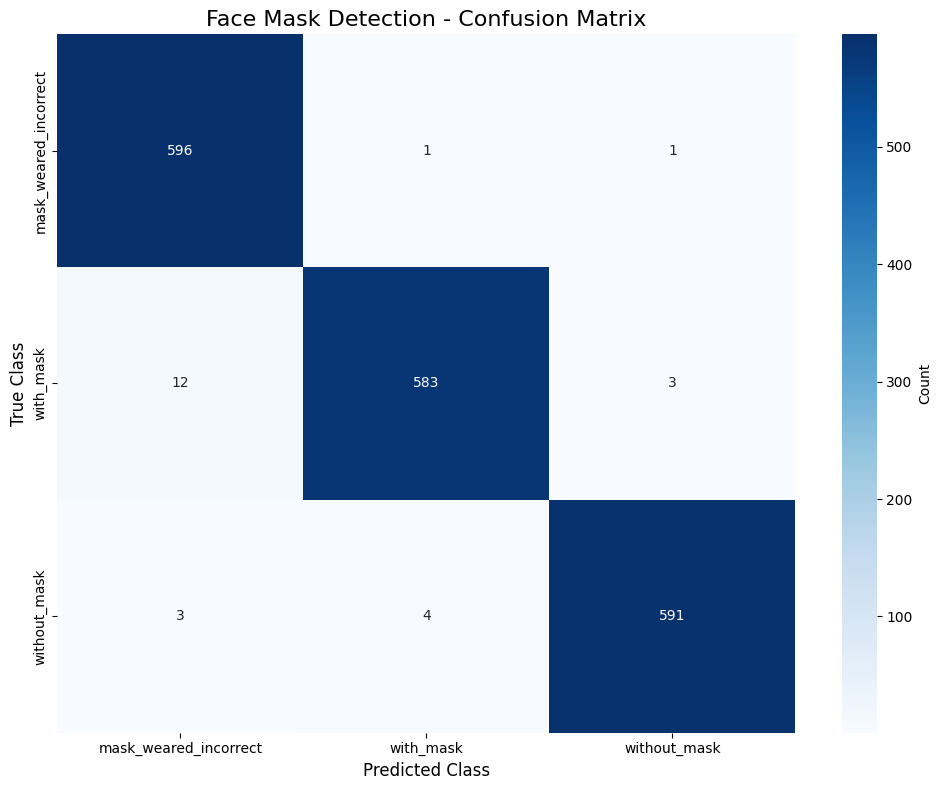


📊 Per-Class Performance:
   mask_weared_incorrect: 0.997 (596/598)
   with_mask: 0.975 (583/598)
   without_mask: 0.988 (591/598)


In [ ]:
# Cell 11: Model Evaluation
# Load the best model and evaluate it
try:
    best_model = keras.models.load_model('best_notebook_model.h5')
    print("Best model loaded successfully!")
    
    if val_gen:
        # Get predictions
        print("🔮 Making predictions on validation set...")
        predictions = best_model.predict(val_gen, verbose=1)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = val_gen.classes
        
        # Get class names
        class_names = list(val_gen.class_indices.keys())
        
        # Calculate accuracy
        accuracy = np.mean(predicted_classes == true_classes)
        print(f"Final Model Accuracy: {accuracy:.4f}")
        
        # Classification report
        print(f"\n📈 Detailed Classification Report:")
        report = classification_report(true_classes, predicted_classes, target_names=class_names)
        print(report)
        
        # Confusion Matrix
        cm = confusion_matrix(true_classes, predicted_classes)
        
        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names,
                   cbar_kws={'label': 'Count'})
        plt.title('Face Mask Detection - Confusion Matrix', fontsize=16)
        plt.xlabel('Predicted Class', fontsize=12)
        plt.ylabel('True Class', fontsize=12)
        plt.tight_layout()
        plt.show()
        
        # Calculate per-class accuracy
        print(f"\nPer-Class Performance:")
        for i, class_name in enumerate(class_names):
            class_acc = cm[i, i] / cm[i, :].sum()
            print(f"   {class_name}: {class_acc:.3f} ({cm[i, i]}/{cm[i, :].sum()})")
    
except Exception as e:
    print(f"Error loading model: {e}")
    print("Make sure you've completed training first!")


In [ ]:
# Cell 13: Real-time Webcam Testing
def test_webcam(model_path='best_notebook_model.h5', img_size=224):
    """Test the model with webcam (run this in a separate environment if needed)"""
    try:
        # Load model
        model = keras.models.load_model(model_path)
        print(f"Model loaded from: {model_path}")
        
        # Load face detector
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        
        # Class names and colors
        classes = ['Mask Incorrect', 'With Mask', 'Without Mask']  # Adjust order based on your class indices
        colors = [(0, 255, 255), (0, 255, 0), (0, 0, 255)]  # Yellow, Green, Red
        
        # Start webcam
        cap = cv2.VideoCapture(0)
        if not cap.isOpened():
            print("Could not open webcam")
            return
        
        print("Webcam detection started!")
        print("Colors: Green=With Mask, Red=Without Mask, Yellow=Incorrect")
        print("Press 'q' to quit, 's' to save screenshot")
        
        frame_count = 0
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            frame = cv2.flip(frame, 1)
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            # Detect faces
            faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(100, 100))
            
            for (x, y, w, h) in faces:
                # Extract and preprocess face
                face_region = frame[y:y+h, x:x+w]
                face_resized = cv2.resize(face_region, (img_size, img_size))
                face_normalized = face_resized.astype(np.float32) / 255.0
                face_batch = np.expand_dims(face_normalized, axis=0)
                
                # Predict
                predictions = model.predict(face_batch, verbose=0)[0]
                class_idx = np.argmax(predictions)
                predicted_class = classes[class_idx]
                confidence = predictions[class_idx]
                
                # Choose color based on prediction
                color = colors[class_idx]
                
                # Draw results
                cv2.rectangle(frame, (x, y), (x + w, y + h), color, 3)
                
                # Main label
                label = f"{predicted_class}: {confidence:.2f}"
                cv2.putText(frame, label, (x, y - 10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
                
                # Show all probabilities
                y_offset = y + h + 25
                for i, (class_name, prob) in enumerate(zip(classes, predictions)):
                    text = f"{class_name}: {prob:.2f}"
                    text_color = colors[i] if prob > 0.3 else (128, 128, 128)
                    cv2.putText(frame, text, (x, y_offset + i * 25),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.6, text_color, 2)
            
            # Info overlay
            cv2.putText(frame, "3-Class Face Mask Detection", (10, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            cv2.putText(frame, "Green=Mask, Red=No Mask, Yellow=Incorrect", 
                       (10, 65), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            cv2.putText(frame, "Press 'q' to quit, 's' to save", 
                       (10, frame.shape[0] - 40), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
            
            cv2.imshow("Face Mask Detection", frame)
            
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break
            elif key == ord('s'):
                # Save screenshot
                filename = f"detection_result_{frame_count:04d}.jpg"
                cv2.imwrite(filename, frame)
                print(f"Screenshot saved: {filename}")
            
            frame_count += 1
        
        cap.release()
        cv2.destroyAllWindows()
        print("Webcam detection completed")
        
    except Exception as e:
        print(f"Error in webcam testing: {e}")
        print("Make sure you have a trained model and webcam available")

# Uncomment the next line to start webcam testing:
test_webcam()
print("Uncomment the last line to start real-time webcam detection!")


✅ Model loaded from: best_notebook_model.h5
🎬 Webcam detection started!
🎨 Colors: Green=With Mask, Red=Without Mask, Yellow=Incorrect
⌨️ Press 'q' to quit, 's' to save screenshot
✅ Webcam detection completed
💡 Uncomment the last line to start real-time webcam detection!
